# Multi-class Logistic Regression [PyTorch]
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)
- Notebook: [MCLR_PyTorch.ipynb](https://github.com/diegoinacio/machine-learning-notebooks/blob/master/Deep-Learning-Models/MCLR_PyTorch.ipynb)
---
Implementation of *Multi-class Logistic Regression* using PyTorch library.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

In [2]:
plt.rcParams['figure.figsize'] = (16, 8)

In [3]:
train_set = datasets.MNIST(root='./mnist', train=True, transform=None, download=True)
test_set = datasets.MNIST(root='./mnist', train=False, transform=None, download=True)
X_train, Y_train = train_set.train_data.numpy(), train_set.train_labels.numpy()
X_test, Y_test = test_set.test_data.numpy(), test_set.test_labels.numpy()

# one hot for multi-class classification
# MNIST = 10 classes [0-9]
y_train_oh = np.zeros((Y_train.size, 10))
y_train_oh[np.arange(Y_train.size), Y_train] = 1
y_test_oh = np.zeros((Y_test.size, 10))
y_test_oh[np.arange(Y_test.size), Y_test] = 1

print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)
print('y_train_oh:', y_train_oh.shape)
print('X_test:', X_test.shape)
print('Y_test:', Y_test.shape)
print('y_test_oh:', y_test_oh.shape)

X_train: (60000, 28, 28)
Y_train: (60000,)
y_train_oh: (60000, 10)
X_test: (10000, 28, 28)
Y_test: (10000,)
y_test_oh: (10000, 10)


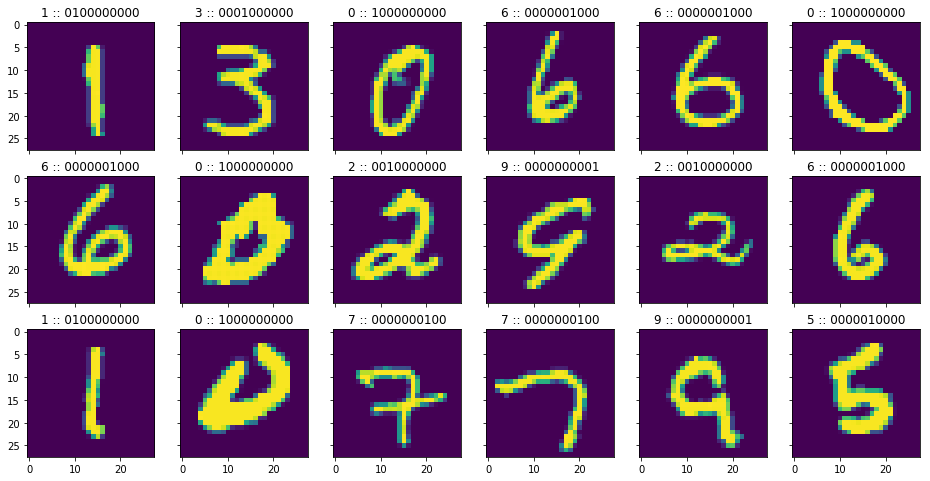

In [4]:
fig, AX = plt.subplots(3, 6, sharex=True, sharey=True)

np.random.seed(1234)
for ax in AX.ravel():
    rindex = np.random.randint(Y_train.size)
    ax.imshow(X_train[rindex])
    # title label + one-hot
    title = '{} :: '.format(Y_train[rindex]) 
    title += ''.join([str(int(e)) for e in y_train_oh[rindex]]) 
    ax.set_title(title)
plt.grid(False)

In [5]:
x_train, y_train = X_train/255, Y_train[np.newaxis].T
x_test, y_test = X_test/255, Y_test[np.newaxis].T

x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (60000, 28, 28)
y_train: (60000, 1)
x_test: (10000, 28, 28)
y_test: (10000, 1)


In [6]:
# reshape Xs
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

x_train: (60000, 784)
x_test: (10000, 784)


## Algorithm
---
Multi-class logistic regression
![mclr](sourceimages/MCLR.png "Multi-Class Logistic Regression")

In [7]:
def CrossEntropyLoss_oh(pred, labels):
    return -torch.mean(torch.sum(labels*torch.log(pred), dim=1))

EPOCHS = 5000  # epochs
ALPHA = 0.005  # learning rate
BATCH = 100    # batch size

# m is the number of examples
# n_x is the input size 28x28=784
m, n_x = x_train.shape

# model
Z = torch.nn.Linear(n_x, 10, bias=True)
torch.nn.init.zeros_(Z.weight)
A = torch.nn.Softmax(dim=1)

# training graph and optimization
optimizer = torch.optim.SGD(Z.parameters(), lr=ALPHA)

# loss and accuracy storage
loss_plot = []; accA_plot = []

for epoch in range(EPOCHS + 1):
    # randomic batch definition
    rbatch = np.random.choice(Y_train.size, size=BATCH)
    # variables initialization
    X = torch.autograd.Variable(torch.FloatTensor(x_train[rbatch]))
    Y = torch.autograd.Variable(torch.FloatTensor(y_train_oh[rbatch]))
    # training, metrics and storage
    optimizer.zero_grad()
    L = CrossEntropyLoss_oh(A(Z(X)), Y)
    L.backward()
    optimizer.step()

    X_ = torch.autograd.Variable(torch.FloatTensor(x_test))
    Y_ = torch.autograd.Variable(torch.FloatTensor(y_test_oh))

    acc = torch.mean(1 - torch.abs(Y_ - A(Z(X_))))*100
    
    loss_plot += [L]; accA_plot += [acc]
    if (not epoch % 1000) and (epoch != 0):
            print('epoch: {0:04d} | loss: {1:.3f} | accuracy: {2:06.2f} %'.format(epoch, L, acc))
W_ = Z.weight.detach().numpy()
B_ = Z.bias.detach().numpy()

epoch: 1000 | loss: 0.786 | accuracy: 090.60 %
epoch: 2000 | loss: 0.538 | accuracy: 092.81 %
epoch: 3000 | loss: 0.461 | accuracy: 093.80 %
epoch: 4000 | loss: 0.437 | accuracy: 094.39 %
epoch: 5000 | loss: 0.537 | accuracy: 094.78 %


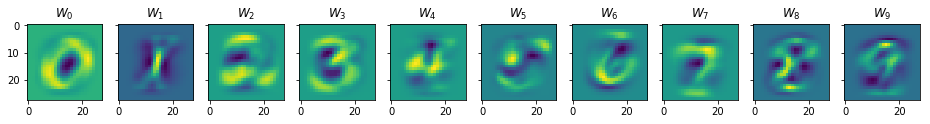

In [8]:
fig, AX = plt.subplots(1, 10, sharey=True)

for i in range(10):
    AX[i].imshow(W_[i].reshape(28, 28))
    AX[i].set_title(r'$W_{}$'.format(i))

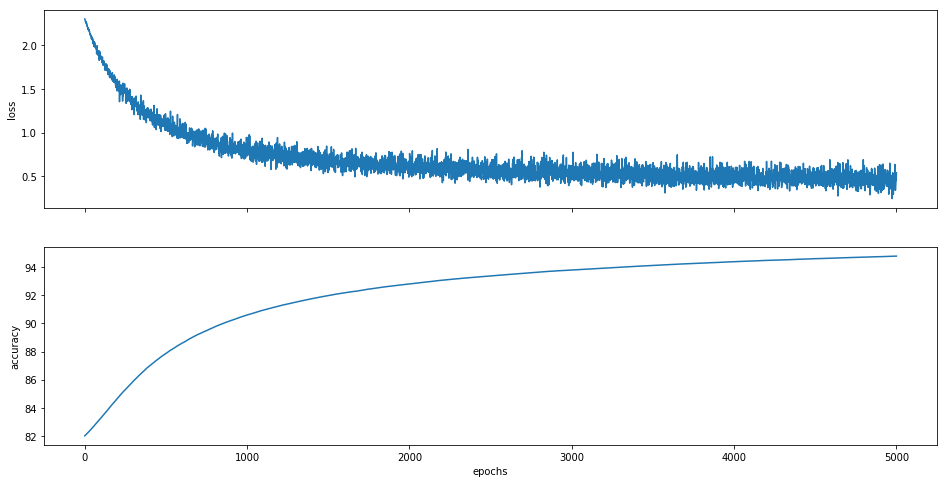

In [9]:
fig, [axA, axB] = plt.subplots(2, 1, sharex=True)

axA.plot(loss_plot)
axA.set_ylabel('loss')
axB.plot(accA_plot)
axB.set_ylabel('accuracy')

plt.xlabel('epochs')

plt.show()

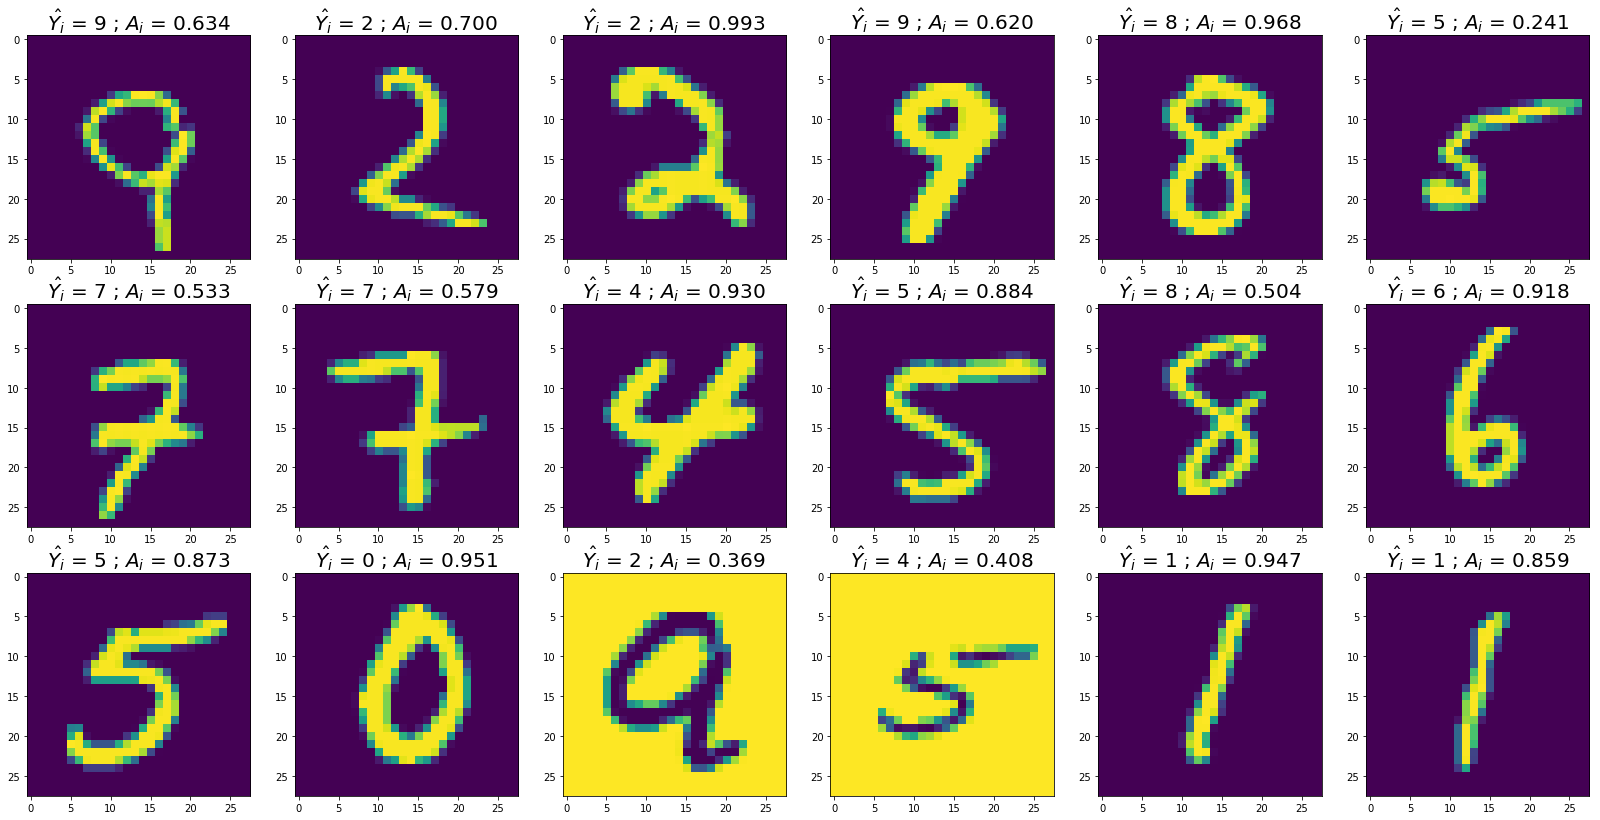

In [10]:
fig, AX = plt.subplots(3, 6, figsize=(2048//72, 1024//72))
AX = [b for a in AX for b in a]

np.random.seed(1)
for ax in AX:
    index = np.random.randint(y_test.size)
    Z_ = np.dot(W_, x_test[index]) + B_
    Y_ = np.argmax(Z_)
    if Y_ == y_test[index]:
        ax.imshow(x_test[index].reshape(28, 28))
    else:
        ax.imshow(1 - x_test[index].reshape(28, 28))
    ez = np.exp(Z_ - Z_.max())
    A_ = ez/ez.sum(); A_ = float(A_.T[Y_])
    ax.set_title(r'$\hat{Y_i}$ = ' + str(Y_) + ' ; $A_i$ = {:.03f}'.format(A_), fontsize=20)